
Processing Image: 5_mp4-14_jpg.rf.28be876c6996527d359df0fe43306fc5.jpg...

Performance Metrics:
Filter                   IoU       Dice      Pixel Acc 
Gaussian                 0.1386    0.2435    0.1402    
Median                   0.1387    0.2435    0.1407    
Wiener                   0.1387    0.2436    0.1411    
Bilateral                0.1385    0.2433    0.1395    
K-Means                  0.2102    0.3474    0.4803    
Mean Shift               0.1383    0.2430    0.1383    
Graph-Based              0.1384    0.2431    0.1385    
Region Growing           0.0000    0.0000    0.8616    
CCA                      1.0000    1.0000    1.0000    
Region Processing        0.7492    0.8566    0.9653    


<ipython-input-10-89f01df05240>:131: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([[filter_name, iou, dice, pixel_acc]], columns=columns)], ignore_index=True)


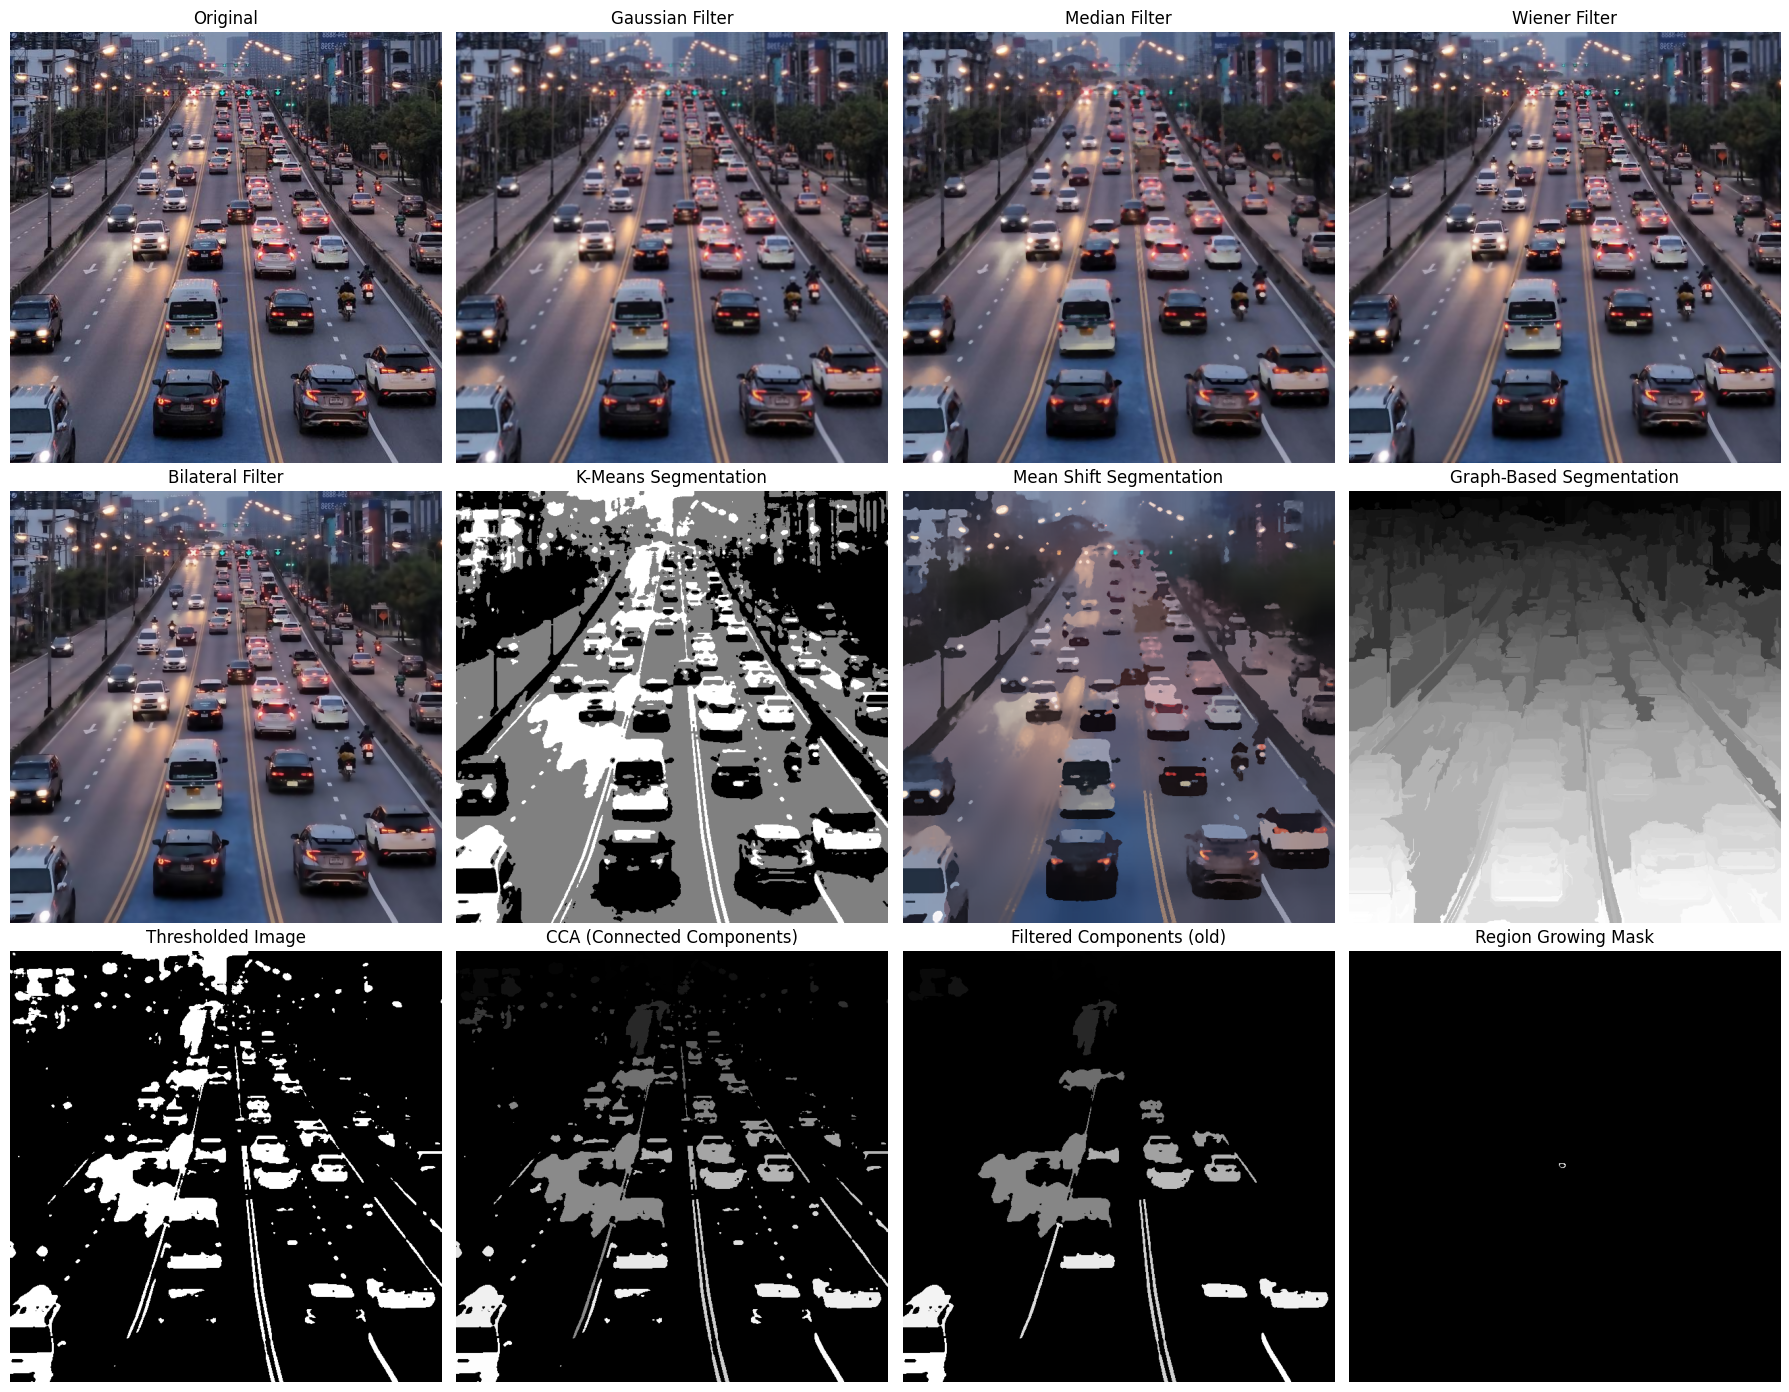

Results saved to: /kaggle/working/output_images/segmentation_results.csv


In [10]:
import cv2
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from skimage.segmentation import felzenszwalb
from skimage.measure import regionprops
from sklearn.cluster import KMeans
from scipy.ndimage import label as ndi_label
from scipy.signal import wiener  # For Wiener filter

# Define input and output directories
input_dir = "/kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/train/images"
output_dir = "/kaggle/working/output_images"
os.makedirs(output_dir, exist_ok=True)  # Create output directory if needed

# Use only the specified image
image_name = "5_mp4-14_jpg.rf.28be876c6996527d359df0fe43306fc5.jpg"
image_path = os.path.join(input_dir, image_name)
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

# DataFrame to store results
columns = ["Filter", "IoU", "Dice", "Pixel Accuracy"]
results_df = pd.DataFrame(columns=columns)

# -----------------------------------------------------------------------------
# FUNCTION TO COMPUTE METRICS
# -----------------------------------------------------------------------------
def compute_metrics(pred, ground_truth):
    """Compute IoU, Dice Coefficient, and Pixel Accuracy."""
    pred = pred.astype(bool)         # Ensure binary mask
    ground_truth = ground_truth.astype(bool)

    intersection = np.logical_and(pred, ground_truth)
    union = np.logical_or(pred, ground_truth)

    IoU = np.sum(intersection) / np.sum(union) if np.sum(union) != 0 else 0
    Dice = (2 * np.sum(intersection)) / (np.sum(pred) + np.sum(ground_truth)) if (np.sum(pred) + np.sum(ground_truth)) != 0 else 0
    Pixel_Accuracy = np.sum(pred == ground_truth) / pred.size

    return IoU, Dice, Pixel_Accuracy

# -----------------------------------------------------------------------------
# REGION GROWING FUNCTION
# -----------------------------------------------------------------------------
def region_growing(gray_image, seed=None, tolerance=15):
    img_float = gray_image.astype(np.float32)
    rows, cols = img_float.shape
    if seed is None:
        seed = (rows // 2, cols // 2)

    seed_val = img_float[seed[0], seed[1]]
    visited = np.zeros_like(img_float, dtype=bool)
    visited[seed[0], seed[1]] = True
    region_mask = np.zeros_like(img_float, dtype=bool)
    region_mask[seed[0], seed[1]] = True
    queue = [seed]

    directions = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]
    
    while queue:
        r, c = queue.pop(0)
        for dr, dc in directions:
            rr, cc = r + dr, c + dc
            if 0 <= rr < rows and 0 <= cc < cols and not visited[rr, cc]:
                if abs(img_float[rr, cc] - seed_val) <= tolerance:
                    region_mask[rr, cc] = True
                    queue.append((rr, cc))
                visited[rr, cc] = True
    return region_mask

# -----------------------------------------------------------------------------
# PROCESS IMAGE
# -----------------------------------------------------------------------------
print(f"\nProcessing Image: {image_name}...")

# ---------------- NOISE REDUCTION ----------------
gaussian_filtered = cv2.GaussianBlur(image, (5, 5), 0)
median_filtered = cv2.medianBlur(image, 5)
wiener_filtered = np.zeros_like(image, dtype=np.uint8)
for c in range(3):
    channel_float = image[..., c].astype(np.float32) / 255.0
    wiener_channel = wiener(channel_float, mysize=5)
    wiener_filtered[..., c] = (wiener_channel * 255.0).clip(0, 255).astype(np.uint8)
bilateral_filtered = cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)

# ---------------- SEGMENTATION ----------------
gray = cv2.cvtColor(median_filtered, cv2.COLOR_RGB2GRAY)
kmeans = KMeans(n_clusters=3, random_state=0, n_init=10)
flat_img = gray.reshape((-1, 1))
kmeans.fit(flat_img)
kmeans_result = kmeans.labels_.reshape(gray.shape)
mean_shift_result = cv2.pyrMeanShiftFiltering(median_filtered, 21, 51)
graph_result = felzenszwalb(median_filtered, scale=100, sigma=0.5, min_size=50)
_, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

# ---------------- CONNECTED COMPONENT ANALYSIS (CCA) ----------------
cca_num_labels, cca_labels = cv2.connectedComponents(thresh)
labeled_img, num_features = ndi_label(thresh)
regions = regionprops(labeled_img)
min_size = 500
for region in regions:
    if region.area < min_size:
        for coords in region.coords:
            labeled_img[coords[0], coords[1]] = 0
predicted_segmentation = labeled_img > 0

# ---------------- REGION GROWING ----------------
region_grow_mask = region_growing(gray, seed=None, tolerance=15)
region_grow_result = (region_grow_mask * 255).astype(np.uint8)

# ---------------- EVALUATION METRICS ----------------
ground_truth = thresh // 255  
filter_names = ["Gaussian", "Median", "Wiener", "Bilateral", "K-Means", "Mean Shift", "Graph-Based", "Region Growing", "CCA", "Region Processing"]
filter_results = [gaussian_filtered, median_filtered, wiener_filtered, bilateral_filtered, kmeans_result, mean_shift_result, graph_result, region_grow_result, cca_labels, predicted_segmentation]

print("\nPerformance Metrics:")
print(f"{'Filter':<25}{'IoU':<10}{'Dice':<10}{'Pixel Acc':<10}")

for filter_name, pred in zip(filter_names, filter_results):
    if isinstance(pred, np.ndarray) and len(pred.shape) == 3:
        pred_gray = cv2.cvtColor(pred, cv2.COLOR_RGB2GRAY)
    else:
        pred_gray = pred.copy()
    if filter_name in ["CCA", "Region Processing", "Graph-Based", "K-Means"]:
        pred_binary = pred_gray > 0
    else:
        pred_binary = pred_gray > 0
    iou, dice, pixel_acc = compute_metrics(pred_binary, ground_truth)
    results_df = pd.concat([results_df, pd.DataFrame([[filter_name, iou, dice, pixel_acc]], columns=columns)], ignore_index=True)
    print(f"{filter_name:<25}{iou:<10.4f}{dice:<10.4f}{pixel_acc:<10.4f}")

# ---------------- DISPLAY RESULTS ----------------
fig, ax = plt.subplots(3, 4, figsize=(18, 14))  # 3x4 grid
ax = ax.flatten()

disp_images = [
    (image, "Original"),
    (gaussian_filtered, "Gaussian Filter"),
    (median_filtered, "Median Filter"),
    (wiener_filtered, "Wiener Filter"),
    (bilateral_filtered, "Bilateral Filter"),
    (kmeans_result, "K-Means Segmentation"),
    (mean_shift_result, "Mean Shift Segmentation"),
    (graph_result, "Graph-Based Segmentation"),
    (thresh, "Thresholded Image"),
    (cca_labels, "CCA (Connected Components)"),
    (labeled_img, "Filtered Components (old)"),
    (region_grow_result, "Region Growing Mask")
]

for i, (img_disp, title) in enumerate(disp_images):
    if len(img_disp.shape) == 2:
        ax[i].imshow(img_disp, cmap="gray")
    else:
        ax[i].imshow(img_disp)
    ax[i].set_title(title)
    ax[i].axis("off")

for j in range(len(disp_images), len(ax)):
    ax[j].axis("off")

plt.tight_layout()
plt.show()

# ---------------- SAVE FINAL RESULTS ----------------
results_csv_path = os.path.join(output_dir, "segmentation_results.csv")
results_df.to_csv(results_csv_path, index=False)
print(f"Results saved to: {results_csv_path}")
